# CAPP 30255 Final Project
## BERT Model
### Piper Kurtz, Wesley Janson, Sam Pavlekovsky

In [ ]:
#Installations in case not there
! pip install transformers datasets evaluate
! pip uninstall -y transformers accelerate
! pip install transformers accelerate
! pip install seaborn

In [20]:
# Import relevant packages
import pandas as pd
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Import relevant packages and data_loader.py
#import data_loader

# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, Conv2d, MaxPool1d, MaxPool2d, Module, Softmax, BatchNorm1d, BatchNorm2d, Dropout, Embedding
from torch.optim import Adam, SGD
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split

import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
 

In [21]:
#Download BERT base
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [22]:
from google.colab import drive 
drive.mount('/content/gdrive')
PATH = "gdrive/MyDrive/Colab Notebooks/"


def load_data(csv):
  # Reads the raw csv file and split into
  # sentences (x) and target (y)
  df = pd.read_csv(csv)  
  return df
data = load_data(f'{PATH}/data.csv')
data=data.rename(columns = {'type':'labels'})
data = data[:50000]
print(data)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
                                                     url  \
0      https://en.wikipedia.org/wiki/Sexhow%20railway...   
1            https://en.wikipedia.org/wiki/Eti%C3%A4inen   
2      https://en.wikipedia.org/wiki/Inverse%20functi...   
3      https://en.wikipedia.org/wiki/Stepping%20on%20...   
4            https://en.wikipedia.org/wiki/Rob%20Bradley   
...                                                  ...   
49995   https://en.wikipedia.org/wiki/Word%20of%20wisdom   
49996          https://en.wikipedia.org/wiki/Ski%20Beatz   
49997     https://en.wikipedia.org/wiki/Crispian%20Mills   
49998        https://en.wikipedia.org/wiki/Russell%20Ash   
49999  https://en.wikipedia.org/wiki/Afterglow%20Mave...   

                          title  \
0        Sexhow railway station   
1                      Etiäinen   
2      Inverse function theorem   
3       

In [23]:
#Tokenize inputs
def preprocess_function(examples):
    word2id = {}
    id2word = []
    indexes_dropped = []
    list_of_inputs = []
    for j, entry in enumerate(examples["intro"]):
        for i,word in enumerate(entry):
            if 7<i<=30:
                if word not in word2id:
                    id2word.append(word)
                    word2id[word] = len(id2word) - 1

        # Convert string of text into string of IDs in a tensor for input to model
        input_as_ids = []
        for i,word in enumerate(entry):
            if 7<i<=30:
                input_as_ids.append(word2id[word])
        if len(input_as_ids) == 23:
          list_of_inputs.append(input_as_ids)
        else:
          indexes_dropped.append(j)
        # final_ids = torch.LongTensor(input_as_ids)
    list_of_inputs = torch.Tensor(list_of_inputs)

    tokenizer = get_tokenizer("basic_english")
    list_of_tokens = [tokenizer(x) for x in list_of_inputs]

    return list_of_tokens, word2id,id2word,indexes_dropped

In [24]:
#Create huggingface dataset style object
train, validate, test = np.split(data.sample(frac=1, random_state=42), 
                                 [int(.6*len(data)), int(.8*len(data))])

# Convert DataFrames to Dataset objects
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)
test_dataset = Dataset.from_pandas(test)

# Apply tokenization to the datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [25]:
#Create data collator for feeding into model
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [26]:
accuracy_metric = load_metric('accuracy')
precision_metric = load_metric('precision')
recall_metric = load_metric('recall')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels)
    recall = recall_metric.compute(predictions=predictions, references=labels)
    
    return {
        'accuracy': accuracy["accuracy"],
        'precision': precision["precision"],
        'recall': recall["recall"],
        'Type I Error': 1 - precision["precision"],  # Type I error is equivalent to (1 - Precision)
        'Type II Error': 1 - recall["recall"],  # Type II error is equivalent to (1 - Recall)
    }


In [27]:
#Establish label dictionaries 
id2label = {0: "HUMAN", 1: "MACHINE"}
label2id = {"HUMAN": 0, "MACHINE": 1}

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)
training_args = TrainingArguments(
    output_dir="output",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
   # label_names = "labels",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,  # use the validation dataset for evaluation
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


trainer.train()




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,Type i error,Type ii error
1,0.000000,0.000003,1.000000,1.000000,1.000000,0.000000,0.000000
2,0.000000,0.000001,1.000000,1.000000,1.000000,0.000000,0.000000
3,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
4,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
5,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000


TrainOutput(global_step=9375, training_loss=0.0008047460518408722, metrics={'train_runtime': 4405.5558, 'train_samples_per_second': 34.048, 'train_steps_per_second': 2.128, 'total_flos': 1.1639003746143168e+16, 'train_loss': 0.0008047460518408722, 'epoch': 5.0})

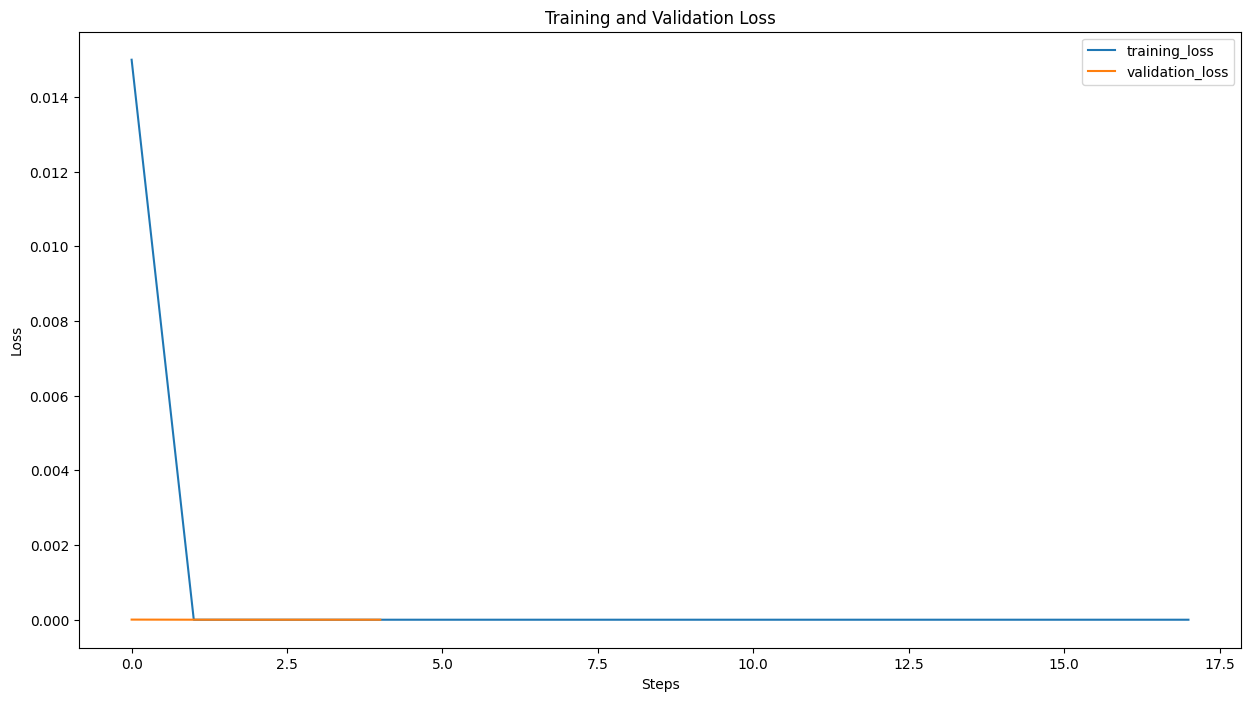

In [29]:
# get the training and validation loss and accuracy values from the trainer object
history = trainer.state.log_history
train_losses = [entry['loss'] for entry in history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]


# Plot training and validation loss over time
plt.figure(figsize=(15,8))
plt.title("Training and Validation Loss")
plt.plot(train_losses,label="training_loss")
plt.plot(eval_losses,label="validation_loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


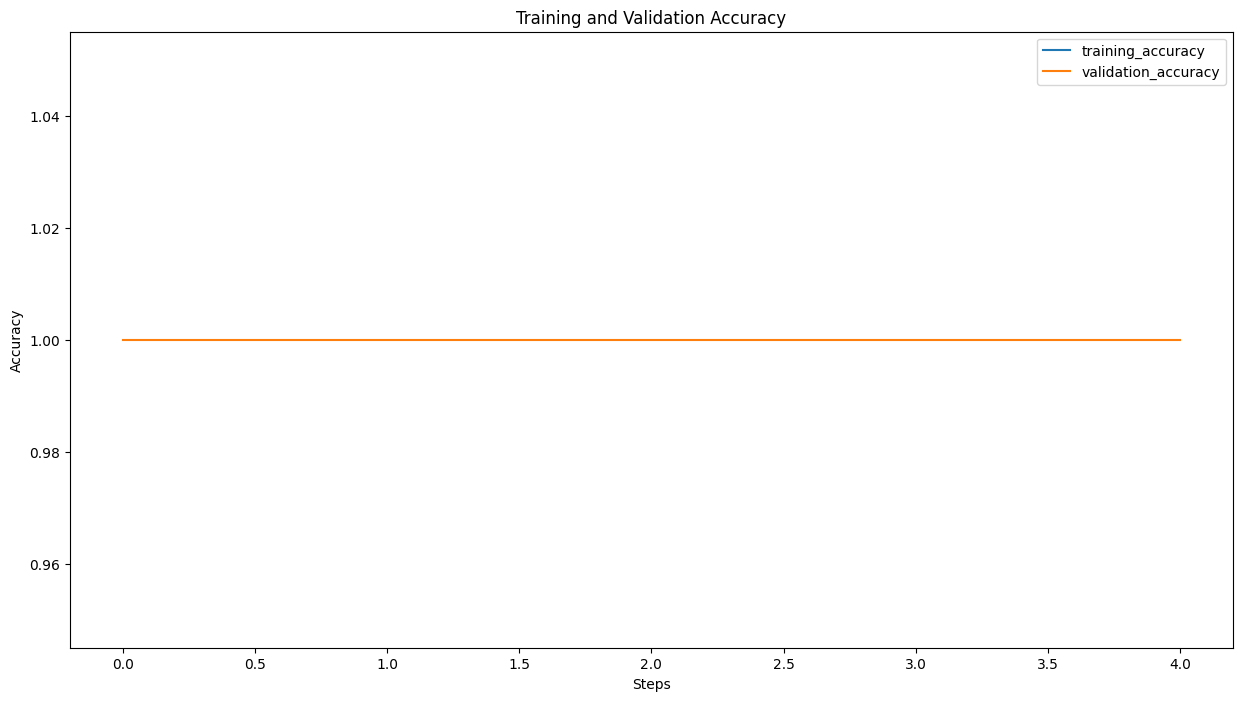

In [30]:
train_accuracies = [entry['accuracy'] for entry in history if 'accuracy' in entry]
eval_accuracies = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]

# Plot training and validation accuracy over time
plt.figure(figsize=(15,8))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracies, label="training_accuracy")
plt.plot(eval_accuracies, label="validation_accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [31]:
# Make predictions on validation set
predictions = trainer.predict(tokenized_val)
# The Trainer hides the columns that are not used by the model 
# (here `labels` because it was not used when creating the dataset), 
# so we set them again
predictions.label_ids = tokenized_val['labels']

# Compute the confusion matrix
cm = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=-1))

# Plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: can't set attribute

In [32]:
# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_test)

print(f'Final performance on test set: {test_results}')

Final performance on test set: {'eval_loss': 1.1930464438592026e-07, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_Type I Error': 0.0, 'eval_Type II Error': 0.0, 'eval_runtime': 93.1015, 'eval_samples_per_second': 107.41, 'eval_steps_per_second': 6.713, 'epoch': 5.0}
